In [1]:
import yfinance as yf
import numpy as np, pandas as pd
import datetime
import matplotlib.pyplot as plt
import sys, os
import pickle as pkl


In [2]:
# look at available info on microsoft

msft = yf.Ticker('msft')
info = msft.info

for key, val in info.items():
    #print(f'{key} : {val}')
    pass

In [3]:
'''# collect data for list of ticks and visualize price over 10 years:
   # only do this once and then load results from disk

start, end = '2010-01-01', '2020-01-01'
ticker_list = [t.replace('\n', '') for t in open('tickers.txt', 'r').readlines()]
close_dict = {}

plt.figure(figsize=(10, 5))

for tick in ticker_list:
    
    try:
        stock = yf.Ticker(tick)
        df = stock.history(start=start, end=end)
        print(tick, len(df))
    
        # only consider if plotted
        if len(df)==2516:
            closes = df['Close']
            close_dict[tick] = closes
            plt.plot(closes, label=tick)
        
    except:
        print(f'{tick} not added')

#close_list = np.array(close_list)
print(len(close_dict)) 
    
plt.legend()
plt.xlabel('Year', fontsize=16)
plt.ylabel('Share price', fontsize=16)

# collect data on all ticks and save to memory, can load this later
pkl.dump(close_dict, open('close_dict.pkl', 'wb'))  '''


"# collect data for list of ticks and visualize price over 10 years:\n   # only do this once and then load results from disk\n\nstart, end = '2010-01-01', '2020-01-01'\nticker_list = [t.replace('\n', '') for t in open('tickers.txt', 'r').readlines()]\nclose_dict = {}\n\nplt.figure(figsize=(10, 5))\n\nfor tick in ticker_list:\n    \n    try:\n        stock = yf.Ticker(tick)\n        df = stock.history(start=start, end=end)\n        print(tick, len(df))\n    \n        # only consider if plotted\n        if len(df)==2516:\n            closes = df['Close']\n            close_dict[tick] = closes\n            plt.plot(closes, label=tick)\n        \n    except:\n        print(f'{tick} not added')\n\n#close_list = np.array(close_list)\nprint(len(close_dict)) \n    \nplt.legend()\nplt.xlabel('Year', fontsize=16)\nplt.ylabel('Share price', fontsize=16)\n\n# collect data on all ticks and save to memory, can load this later\npkl.dump(close_dict, open('close_dict.pkl', 'wb'))  "

Text(0, 0.5, 'Share price')

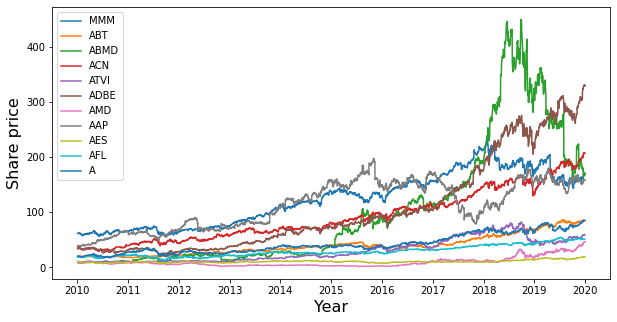

In [4]:
# load close_dict for all ticks from disk
close_dict = pkl.load(open('close_dict.pkl', 'rb'))

# plot the first few ticks:
n_ticks = 10
plt.figure(figsize=(10, 5))

for i, (tick, traj) in enumerate(close_dict.items()):
    plt.plot(traj, label=tick)
    
    if i==n_ticks:
        break
    
plt.legend()
plt.xlabel('Year', fontsize=16)
plt.ylabel('Share price', fontsize=16)

In [100]:
def sma(traj, window):
    '''calculate simple rolling average over select window'''
    
    sma = np.convolve(traj, np.ones(window)/window, mode='valid')
    #sma = []
    #for i in range(0, len(traj)-window):
        #sma.append(np.mean(traj[i:i+window]))
    return np.array(sma)

def check_switch(sma_short, sma_long):
    '''checks when short and long sma crossover over occurs'''
    '''return action list: 0= nothing, [0, 1]=sell, [1, 0]=buy'''
    
    sma_diff = sma_long-sma_short
    actions = []
    
    for i in range(len(sma_diff)-1):
        
        # check if change in sign
        if sma_diff[i]*sma_diff[i+1] < 0:
            
            # sma long is greater: sell!
            if sma_diff[i+1] > sma_diff[i]:
                actions.append([0, 1])
            
            # sma short is greater: buy!
            else: actions.append([1, 0])
        
        # no change: take no action
        else: actions.append([0, 0])
    
    return np.array(actions)

def generate_sma_actions(w_short):

    # compute sma for two window sizes, traditional seperated by factor of 2
    w_long = 2*w_short
    corr_factor = (w_long - w_short)//2
    sma_short, sma_long, actions = {}, {}, {}

    for tick, traj in close_dict.items():
        sma_short[tick] = sma(traj, w_short)[corr_factor:-corr_factor]
        sma_long[tick] = sma(traj, w_long)
        actions[tick] = check_switch(sma_short[tick], sma_long[tick])

    print(len(sma(traj, w_short)[corr_factor:-corr_factor]), len(sma(traj, w_long)))
    return (sma_short, sma_long, actions)

# generate smas for each of the following short values
short_list = [10, 20, 30, 50] # bug with odds
sma_dict = {}

for w_short in short_list:
    sma_dict[w_short] = generate_sma_actions(w_short)


2497 2497
2477 2477
2457 2457
2417 2417


23.564333333333334
23.564333333333334


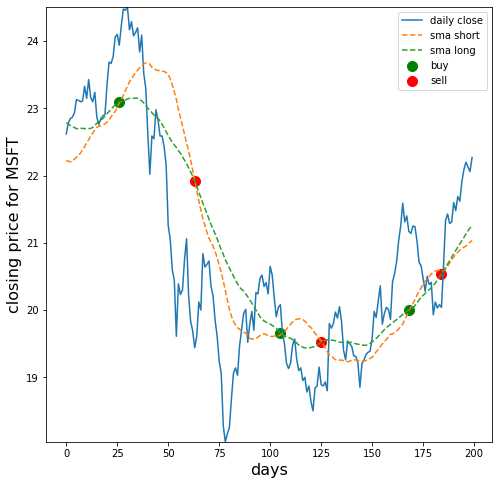

In [102]:
# show proposed buying strategy for an example stock

# load smas and actions from dict
w_short = 30
w_long = w_short*2
sma_short, sma_long, actions = sma_dict[w_short]

plt.figure(figsize=(8, 8))
test_tick = 'MSFT'
max_plot = 200
shift = (w_short+w_long)//2

xis = np.arange(max_plot)

print(np.mean(close_dict[test_tick][w_long:w_long+w_short]))
print(np.mean(close_dict[test_tick][w_long:w_long+w_short]))

plt.plot(xis, close_dict[test_tick][shift:max_plot+shift], label='daily close')
plt.plot(xis, sma_short[test_tick][:max_plot], label='sma short', linestyle='dashed')
plt.plot(xis, sma_long[test_tick][:max_plot], label='sma long', linestyle='dashed')

# plot buys and sells seperately
plt.scatter(xis, actions[test_tick][:max_plot, 0]*sma_long[test_tick][:max_plot], label='buy', 
            color='g', s=100)
plt.scatter(xis, actions[test_tick][:max_plot, 1]*sma_long[test_tick][:max_plot], label='sell', 
            color='r', s=100)
plt.ylim(np.min(close_dict[test_tick][w_short:max_plot+w_short]), 
         np.max(close_dict[test_tick][w_short:max_plot+w_short]))
plt.xlabel('days', fontsize=16)
plt.ylabel(f'closing price for {test_tick}', fontsize=16)
plt.legend()

In [103]:
# set up a portfolio to test various investing strategiess

class Portfolio:
    '''stores shares of each stock and cash on hand
       stock_dict formatted by 'tick':n_shares
    '''
    
    def __init__(self, cash, init_dict={}):
        '''initialize empty dict by default'''
        
        self.cash = cash
        self.stock_dict = init_dict
        
    def get_price(self, tick, time):
        '''get the instantaneous price for a stock'''
        
        return close_dict[tick][time]
        
    def buy(self, tick, n_shares, time):
        '''purchase n_shares of tick for price'''
        
        price = self.get_price(tick, time)
        self.stock_dict[tick] += n_shares
        self.cash -= n_shares*price

    
    def sell(self, tick, n_shares, time):
        '''sell n_shares of tick for price'''
        
        price = self.get_price(tick, time)
        
        # check if have enough to sell
        if n_shares < self.stock_dict[tick]:
            self.stock_dict[tick] -= n_shares
            self.cash += n_shares*price
        
        # otherwise sell all and subtract remaining funds from cash
        else:
            self.cash += self.stock_dict[tick]*price
            self.stock_dict[tick] = 0
    
    def liquidate(self, time):
        '''sell all stocks into cash'''
        
        for tick, all_shares in self.stock_dict.items():
            self.sell(tick, all_shares, time)
            
    def get_stock_value(self, tick, time):
        '''returns portfolio value of a single stock at a given time'''
        
        return self.get_price(tick, time)*self.stock_dict[tick]
    
    def get_value(self, time, n_top=5):
        '''sum cash on hand with stock value and return'''
        
        val_list = []
        tick_list = []
        for tick, all_shares in self.stock_dict.items():
            price = self.get_price(tick, time)
            val_list.append(all_shares*price)
            tick_list.append(tick_list)
            
        return self.cash + np.sum(val_list)
     

-6.548361852765083e-10


Text(0, 0.5, 'portfolio value')

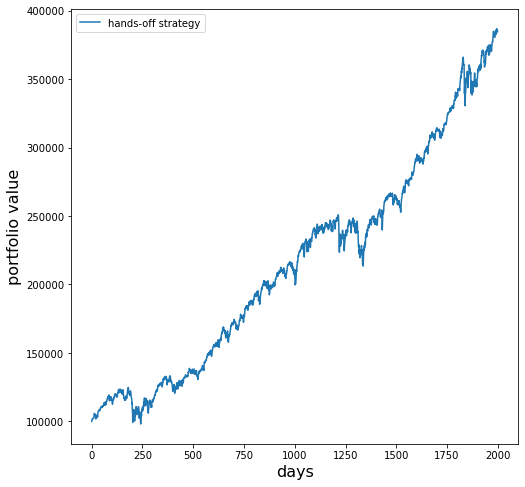

In [104]:
# as a control just buy an equal amount of each stock and don't sell until 2020

def make_even_init(ti, initial_cash=100000):
    
    n_ticks = len(close_dict)
    cash_per_tick = initial_cash / n_ticks

    # generate initial shares per stock:
    init_dict = {}
    spent_cash = 0
    for tick, closes in close_dict.items():

        # buy all at very first price
        init_price = closes[ti]
        n_shares = cash_per_tick / init_price
        init_dict[tick] = n_shares
        spent_cash += init_price*n_shares

    # initialized the portfolio
    extra_cash = initial_cash - spent_cash
    
    return extra_cash, init_dict
    

# initial and final times -- there should be adquate buffer for the long sma window
ti, tf = 200, 2200

# initialize even portfolio
extra_cash, init_dict = make_even_init(ti, initial_cash=100000)
port_control = Portfolio(extra_cash, init_dict)
print(port_control.cash) #, '\n', port_control.stock_dict)

# report totally portfolio value over time
handsoff_val_list = []
for t in range(ti, tf):
    handsoff_val_list.append(port_control.get_value(t))
    
plt.figure(figsize=(8, 8))
plt.plot(handsoff_val_list, label='hands-off strategy')
plt.legend()
plt.xlabel('days', fontsize=16)
plt.ylabel('portfolio value', fontsize=16)

In [106]:
# tune purchasing strategy based on sma crossover
# wiki soybean example: https://en.wikipedia.org/wiki/Trend_following

def invert_actions(actions):
    '''convert from dict of trajs to traj of dicts'''

    traj_list = [val for val in actions.values()]
    n_steps = len(traj_list[0])
    
    buy_trajs = [[] for n in range(n_steps)]
    sell_trajs = [[] for n in range(n_steps)]
    
    print(len(buy_trajs))
    
    for tick, traj in actions.items():
        
        for t, act in enumerate(traj):
            
            # add to buy_trajs
            if act[0] == 1:
                buy_trajs[t].append(tick)
                
            # add to sell_trajs
            if act[1] == 1:
                sell_trajs[t].append(tick)
                
    return (buy_trajs, sell_trajs)
    

In [107]:
# start a new portfolio with same conditions
# ti, tf = 1000, 2000

# try buy/sell 50% of current shares at a sell point, 
perc_transact = 0.5

# buy minimum of $100 per buy event (does not apply to neutrals)
min_buy = 100

# collect simulation output for each condition
all_values = []
all_final_portfolios = []
write_mod = 100

for w_short in short_list:
    _, _, actions = sma_dict[w_short]
    buy_trajs, sell_trajs = invert_actions(actions)
    buy_sell_dict[w_short] = (buy_trajs, sell_trajs)

    # initialize portfolio and simulation
    extra_cash, init_dict = make_even_init(ti, initial_cash=100000)
    trend_port = Portfolio(0, init_dict)
    val_list = []

    for t in range(ti, tf): #tf

        # shift to fit sma and actions
        t_sma = t+ 3*w_short//2

        # get lists of buys and sells at given timestep
        buy_list = buy_trajs[t_sma]
        sell_list = sell_trajs[t_sma]
        stock_dict = trend_port.stock_dict

        for b_tick in buy_list:

            # calculate new shares from current shares and buy
            current_shares = stock_dict[b_tick]
            n_buy = current_shares*perc_transact

            # make sure to buy minimum amount:
            price_buy = trend_port.get_price(b_tick, t)
            if n_buy*price_buy < min_buy:
                n_buy = min_buy / price_buy

            trend_port.buy(b_tick, n_buy, t)

        for s_tick in sell_list:

            # calculate new shares from current shares and sell
            current_shares = stock_dict[b_tick]
            n_sell = current_shares*perc_transact
            trend_port.sell(s_tick, n_sell, t)

        # determine remaining cash after all transactions
        cash_remaining = trend_port.cash

        # leave no cash by distributions +- cash across all neutral stock
        neutral_list = [tick for tick in stock_dict.keys() if tick not in (buy_list + sell_list)]
        cash_per_neutral = cash_remaining / (len(neutral_list))
        value_per_neutral = np.mean([trend_port.get_stock_value(tick, t) for tick in neutral_list])

        # use positive remainig cash to buy neutral stocks
        if cash_remaining > 0:
            for tick in neutral_list:
                n_shares = cash_per_neutral / trend_port.get_price(tick, t)
                trend_port.buy(tick, n_shares, t)

        # sell neutral stocks to recover cash deficit
        else:
            for tick in neutral_list:

                # adjust purchase based on current value of stock
                cash_adjusted = -cash_per_neutral * trend_port.get_stock_value(tick, t) / value_per_neutral
                n_shares = cash_adjusted / trend_port.get_price(tick, t)
                trend_port.sell(tick, n_shares, t)

        final_cash = trend_port.cash
        val_list.append(trend_port.get_value(t))

        #write_mod=1
        if (t-ti)%write_mod == 0:
            print(np.around([t,cash_remaining,cash_per_neutral, final_cash]))
            #print(buy_list, sell_list)
            
    # update simulation info
    all_values.append(val_list)
    all_final_portfolios.append(trend_port)


2496
[  200. -2908.    -7.    -0.]
[  300. -2790.    -7.    -0.]
[  400. -5320.   -13.     0.]
[  500. -2157.    -5.     0.]
[  600. -2762.    -7.     0.]
[  700. -4365.   -10.     0.]
[  800. -2467.    -6.    -0.]
[  900. -4364.   -11.    -0.]
[1000. 1150.    3.   -0.]
[ 1100. -5191.   -13.    -0.]
[ 1200. -1607.    -4.     0.]
[1300.  667.    2.    0.]
[ 1400. -5800.   -15.     0.]
[ 1500. -4786.   -12.    -0.]
[1.60e+03 5.16e+02 1.00e+00 0.00e+00]
[ 1700. -4930.   -13.    -0.]
[ 1.80e+03 -5.52e+02 -1.00e+00 -0.00e+00]
[ 1900. -4206.   -11.     0.]
[ 2000. -5510.   -14.    -0.]
[ 2100. -1469.    -3.    -0.]
2476
[ 200. -958.   -2.   -0.]
[300. 666.   2.   0.]
[  400. -7064.   -18.    -0.]
[  500. -2043.    -5.     0.]
[  600. -1516.    -4.    -0.]
[ 700. 1745.    4.    0.]
[ 800. 3345.    8.   -0.]
[  900. -7791.   -18.     0.]
[1000.  126.    0.   -0.]
[1100.  164.    0.   -0.]
[1200. 1532.    4.    0.]
[ 1300. -7349.   -18.     0.]
[1400. -810.   -2.    0.]
[1500. -909.   -2.    0.

Text(0, 0.5, 'portfolio value')

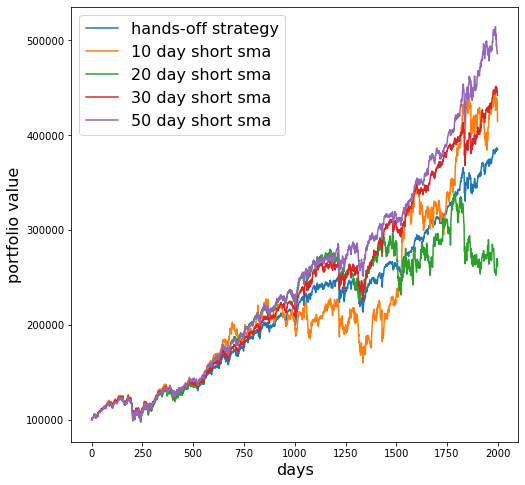

In [110]:
# plot which value over time for each strategy

plt.figure(figsize=(8, 8))

plt.plot(handsoff_val_list, label='hands-off strategy')

for w_short, val_list in zip(short_list, all_values):
    plt.plot(val_list, label=f'{w_short} day short sma')

plt.legend(fontsize=16)
plt.xlabel('days', fontsize=16)
plt.ylabel('portfolio value', fontsize=16)

In [ ]:
# which stocks have been purchased the most for each strategy